## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


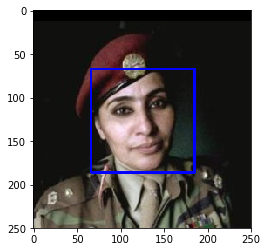

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]


##Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_count_in_human = 0 
human_count_in_dog = 0

for file in human_files_short:
    if face_detector(file) == True:
        human_count_in_human += 1
        
for file in dog_files_short:
    if face_detector(file) == True:
        human_count_in_dog += 1

print(f"percentage of the first 100 images in human_files have a detected human face: {human_count_in_human}%")
print(f"percentage of the first 100 images in dog_files have a detected human face: {human_count_in_dog}%")

percentage of the first 100 images in human_files have a detected human face: 100%
percentage of the first 100 images in dog_files have a detected human face: 11%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer: In my opinion this is somewhat of reasonable expectation to pose on the user given my experience with current facial recognition software used by online courses for user verification, however it limits the system's functionality and as noted above could lead to unneccessarily frustrated users. To detect humans in images without requiring a clearly presented face, a CNN could be trained on a wide variety of images, some where the face is not clearly presented either due to an obstruction, lighting or positioning. This would allow the system to learn to detect edge features and thus make the system more robust. 

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [11]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

human_files_short = human_files[:100]
dog_files_short = train_files[:100]

dog_count_in_human = 0 
dog_count_in_dog = 0

for file in human_files_short:
    if dog_detector(file) == True:
        dog_count_in_human += 1
        
for file in dog_files_short:
    if dog_detector(file) == True:
        dog_count_in_dog += 1

print(f"percentage of the first 100 images in human_files have a detected a dog: {dog_count_in_human}%")
print(f"percentage of the first 100 images in dog_files have a detected a dog: {dog_count_in_dog}%")

percentage of the first 100 images in human_files have a detected a dog: 0%
percentage of the first 100 images in dog_files have a detected a dog: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 100.70it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ My solution is based on the hinted architecture due to the fact that it specifies a model that trains relatively fast on a CPU and attains >1% test accuracy in 5 epochs. 

This CNN architecture should work well for the image classification task because;

1. Low accuracy threshold hurdle

2. It consists of 3 convolutional layers with 3 max pooling layers which reduce the dimensionality of the images by reducing the number of pixels in the output from each preceeding convolutional layer. This reduces the number of parameters and ultimately reduces overfitting.

3. The use of the relu activation function for the hidden layers allows for faster learning and also avoids the vanishing gradient problem.

4. The filters used in each convolutional layer are 16, 32 and 64 which isn't too large a network such that training can be done in a reasonable time. This seems sufficient specifically because the level of accuracy required is low.

5. The hinted architecture also applies drop out regularization which randomly knocks out units and causes the network to become less sensitive to specific weights to as to further reduce overfitting.

6. The final layer having 133 nodes to match the number of classes of dog breeds also makes the architecture seem suitable for the task.

The best results again were obtained with the one densely connected layer using 'relu' activation function with a dropout of 40% connected to another densely connected output layer with 'softmax' activation function, since this activation function gives probabilities for multiple different classes. . (Test accuracy: 9.4498%)

 

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Define architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)        0         
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 32s 5ms/step - loss: 4.8934 - acc: 0.0190 - val_loss: 4.6017 - val_acc: 0.0443
Epoch 2/10
6680/6680 [==============================] - 31s 5ms/step - loss: 4.4254 - acc: 0.0528 - val_loss: 4.3216 - val_acc: 0.0551
Epoch 3/10
6680/6680 [==============================] - 31s 5ms/step - loss: 3.9576 - acc: 0.1109 - val_loss: 4.1218 - val_acc: 0.0994
Epoch 4/10
6680/6680 [==============================] - 31s 5ms/step - loss: 3.3078 - acc: 0.2293 - val_loss: 4.1341 - val_acc: 0.0862
Epoch 5/10
6680/6680 [==============================] - 31s 5ms/step - loss: 2.3886 - acc: 0.4133 - val_loss: 4.5544 - val_acc: 0.0982
Epoch 6/10
6680/6680 [==============================] - 31s 5ms/step - loss: 1.5365 - acc: 0.6124 - val_loss: 5.1005 - val_acc: 0.1030
Epoch 7/10
6680/6680 [==============================] - 31s 5ms/step - loss: 0.9474 - acc: 0.7533 - val_loss: 6.5188 - val_acc: 0.0874
Epoch 8/

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 7.2967%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 302us/step - loss: 12.5301 - acc: 0.1166 - val_loss: 11.2574 - val_acc: 0.1964
Epoch 2/20
6680/6680 [==============================] - 2s 254us/step - loss: 10.7620 - acc: 0.2539 - val_loss: 10.7719 - val_acc: 0.2599
Epoch 3/20
6680/6680 [==============================] - 2s 254us/step - loss: 10.3908 - acc: 0.2990 - val_loss: 10.4913 - val_acc: 0.2922
Epoch 4/20
6680/6680 [==============================] - 2s 253us/step - loss: 10.1049 - acc: 0.3304 - val_loss: 10.3287 - val_acc: 0.2934
Epoch 5/20
6680/6680 [==============================] - 2s 253us/step - loss: 9.9597 - acc: 0.3491 - val_loss: 10.2010 - val_acc: 0.3078
Epoch 6/20
6680/6680 [==============================] - 2s 252us/step - loss: 9.8488 - acc: 0.3644 - val_loss: 10.2100 - val_acc: 0.3150
Epoch 7/20
6680/6680 [==============================] - 2s 254us/step - loss: 9.7661 - acc: 0.3716 - val_loss: 10.0991 - val_ac

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 37.9187%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [25]:
### Obtain bottleneck features from another pre-trained CNN.

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_resnet50 = bottleneck_features['train']
valid_resnet50 = bottleneck_features['valid']
test_resnet50 = bottleneck_features['test']

In [26]:
# feature extractor shape
train_resnet50.shape

(6680, 1, 1, 2048)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

Steps taken to get final CNN architecture 
            
I Chose to use the residual net (resnet50) model which is pre-trained on imagenet weights. This model was chosen because of its ability to train hundreds or even thousands of layers and still achieve great performance. 

I decided to use a single global average pooling layer at the top of the network, as is common in many deep networks today to reduce the computational power necessary and liklihood of overfitting.

The global average pooling layer was then fed to a densely connected layer with 256 nodes using 'relu' activation function with a dropout of 20%, connected to another densely connected output layer with 'softmax' activation function. 

The final layer has 133 nodes to match the number of our classes.

I then experimented with different combinations i.e. 

1 vs 2 fully connected layers

256 vs 512 vs 1024 nodes (output nuerons)

20 vs 25 vs 40% drop out rates

SGD vs Adam vs rmsprop as optimizers

Results ranged from between 76% and 80.9%
              
              
Why this architecture is suitable for the problem? 

The archiecture was suitable for the problem given its performance. 80.9% accuracy was achieved and the training time was short. This is because he resnet50 model has been pre-trained on imagenet weights and the knowledge (edges, shapes, faces) it has learned from that task is now being re-used for our specific classification task. 



In [72]:
### Define your architecture.

from keras.layers import Dropout

resnet50_model = Sequential()
resnet50_model.add(GlobalAveragePooling2D(input_shape=train_resnet50.shape[1:]))
resnet50_model.add(Dense(256, activation='relu'))
resnet50_model.add(Dropout(0.20))
resnet50_model.add(Dense(133, activation='softmax'))

resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_11  (None, 2048)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 256)               524544    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [73]:
### Compile the model.

resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [74]:
###Train the model.

from keras.callbacks import ModelCheckpoint 

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.resnet50.hdf5', 
                               verbose=1, save_best_only=True)

resnet50_model.fit(train_resnet50, train_targets, 
          validation_data=(valid_resnet50, valid_targets),
          epochs=15, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/15
6680/6680 [==============================] - 3s 465us/step - loss: 2.1111 - acc: 0.4876 - val_loss: 0.8567 - val_acc: 0.7269
Epoch 2/15
6680/6680 [==============================] - 2s 358us/step - loss: 0.7305 - acc: 0.7750 - val_loss: 0.7750 - val_acc: 0.7629
Epoch 3/15
6680/6680 [==============================] - 2s 346us/step - loss: 0.4712 - acc: 0.8487 - val_loss: 0.7589 - val_acc: 0.7737
Epoch 4/15
6680/6680 [==============================] - 2s 352us/step - loss: 0.3583 - acc: 0.8823 - val_loss: 0.6753 - val_acc: 0.7820
Epoch 5/15
6680/6680 [==============================] - 2s 346us/step - loss: 0.2638 - acc: 0.9126 - val_loss: 0.6478 - val_acc: 0.8048
Epoch 6/15
6680/6680 [==============================] - 2s 331us/step - loss: 0.2068 - acc: 0.9308 - val_loss: 0.6782 - val_acc: 0.7952
Epoch 7/15
6680/6680 [==============================] - 2s 338us/step - loss: 0.1653 - acc: 0.9481 - val_loss: 0.6316 - val_acc: 0.8072
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [75]:
### Load the model weights with the best validation loss.

resnet50_model.load_weights('saved_models/weights.best.resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [76]:
###Calculate classification accuracy on the test dataset.

resnet50_predictions = [np.argmax(resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_resnet50]

test_accuracy = 100*np.sum(np.array(resnet50_predictions)==np.argmax(test_targets, axis=1))/len(resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.9809%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [49]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def resnet50_predict_breed(img_path):
 
    #extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    
    #obtain predicted vector
    predicted_vector = resnet50_model.predict(bottleneck_feature)
    
    #obtain predicted index
    predicted_index = np.argmax(predicted_vector)
    
    breed = dog_names[predicted_index]
    
    return breed
 


---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [54]:
### Write your algorithm.
### Feel free to use as many code cells as needed.


def dog_breed_predictor(img_path):
   
  
    #detect if image is dog
    dog = dog_detector(img_path)
    
    #detect if image contains a human face
    human = face_detector(img_path)
    
    #predict dog_breed 
    dog_breed = resnet50_predict_breed(img_path)
    
    #load image
    img = cv2.imread(img_path)
    
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()
    
    if dog:
        return("This dog looks like a {}".format(dog_breed))
    elif human:
        return("This human resembles a {}".format(dog_breed))
    else:
        return("Error: This is neither a dog nor a human")   
    

    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer: The output is about what I had expected. The model achieved 78% test accuracy, but mis-classified a couple breeds e.g. a rottweiler mistaken for a beauceron, a doberman pinscher mistaken for a german pinscher however these breeds have similar markings and features and could easily be mistaken by a human. One human was also mis classified possibly because of the angle of the picture.

Three possible areas where we could work on improving this algorithm is:

1. Provide a larger training set of dog and human images for the model with different angles, lighting, back-grounds
3. Furter optimization - I was able to improve accuracy from 77% to 78.5% by changing the optimzer from 'rmsprop' to 'sgd' this improved the classification performance.
4. Increase the depth of the NN

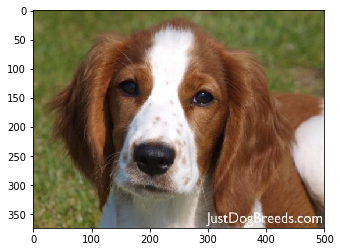

'This dog looks like a in/130.Welsh_springer_spaniel'

In [51]:
## Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

dog_breed_predictor('images/Welsh_springer_spaniel_08203.jpg')

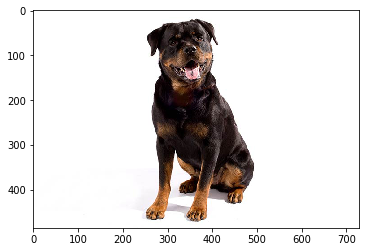

'This dog looks like a in/018.Beauceron'

In [52]:
dog_breed_predictor('images/Rottweiler-On-White-10.jpg')

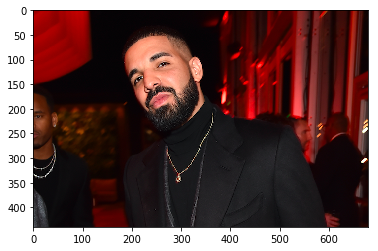

'Error: This is neither a dog nor a human'

In [55]:
dog_breed_predictor('images/drake-gets-beatles-tattoo.png')

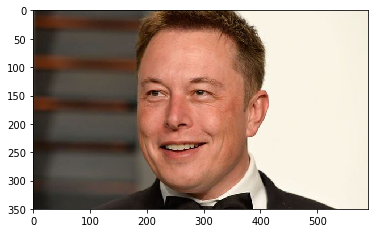

'This human resembles a in/044.Cane_corso'

In [56]:
dog_breed_predictor('images/elon-musk-news-1164574.jpg')

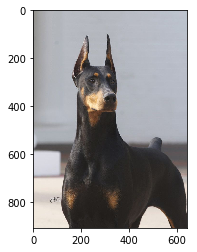

'This dog looks like a in/070.German_pinscher'

In [57]:
dog_breed_predictor('images/doberman pinscher.jpg')

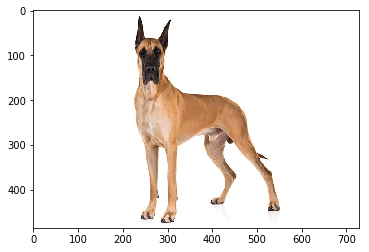

'This dog looks like a in/078.Great_dane'

In [58]:
dog_breed_predictor('images/Great-Dane-On-White-01.jpg')

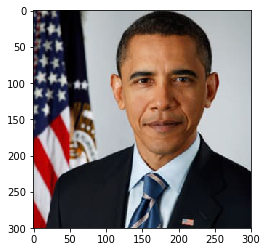

'This human resembles a in/123.Pomeranian'

In [59]:
dog_breed_predictor('images/barack-obama-12782369-1-402.jpg')

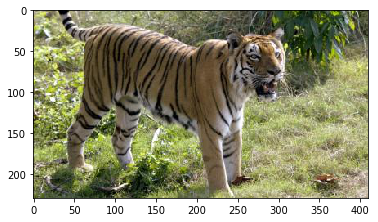

'Error: This is neither a dog nor a human'

In [60]:
dog_breed_predictor('images/Tigers.jpg')

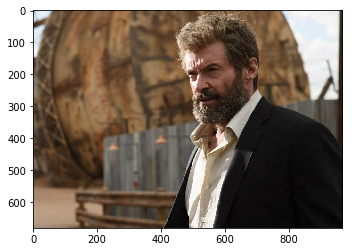

'This human resembles a in/009.American_water_spaniel'

In [61]:
dog_breed_predictor('images/logan-hugh-jackman-wolverine-0.jpg')

# Please download your notebook to submit

In order to submit, please do the following:
1.  Download an HTML version of the notebook to your computer using 'File: Download as...'
2.  Click on the orange Jupyter circle on the top left of the workspace.
3.  Navigate into the dog-project folder to ensure that you are using the provided dog_images, lfw, and bottleneck_features folders; this means that those folders will *not* appear in the dog-project folder.  If they do appear because you downloaded them, delete them.
4.  While in the dog-project folder, upload the HTML version of this notebook you just downloaded.  The upload button is on the top right.
5.  Navigate back to the home folder by clicking on the two dots next to the folder icon, and then open up a terminal under the 'new' tab on the top right
6.  Zip the dog-project folder with the following command in the terminal:
 `zip -r dog-project.zip dog-project`
7.  Download the zip file by clicking on the square next to it and selecting 'download'.  This will be the zip file you turn in on the next node after this workspace!